In [24]:
import sys

sys.path.append("..")

import nest_asyncio

nest_asyncio.apply()

from pydantic_ai import Agent, RunContext
from pydantic_ai.messages import ModelMessage
from pydantic_ai.models.gemini import GeminiModel
from pydantic_ai.providers.google_vertex import GoogleVertexProvider
import sqlalchemy as sa
from pydantic import BaseModel, ConfigDict
from pathlib import Path
from sqlmodel import SQLModel, select, text
from sqlmodel.ext.asyncio.session import AsyncSession
from sqlalchemy.ext.asyncio import create_async_engine, AsyncEngine
import csv
import uuid

from src.schema import (
    Customer,
    Order,
    OrderItem,
    Product
)

In [26]:
BASE_ASSETS_PATH = Path("..") / "src" / "assets"

with (BASE_ASSETS_PATH / "customers.csv").open("r") as f:
    customers = [
        Customer.model_validate(row)
        for row in csv.DictReader(f)
    ]

with (BASE_ASSETS_PATH / "products.csv").open("r") as f:
    products = [
        Product.model_validate(row)
        for row in csv.DictReader(f)
    ]

with (BASE_ASSETS_PATH / "orders.csv").open("r") as f:
    orders = [
        Order.model_validate(row)
        for row in csv.DictReader(f)
    ]

with (BASE_ASSETS_PATH / "order_items.csv").open("r") as f:
    order_items = [
        OrderItem.model_validate(row)
        for row in csv.DictReader(f)
    ]

database_path = BASE_ASSETS_PATH / "database.db"
if database_path.exists():
    database_path.unlink()

engine = create_async_engine(f"sqlite+aiosqlite:///{str(database_path.absolute())}", echo=False)
async_session = AsyncSession(engine)
async with engine.begin() as conn:
    await conn.run_sync(SQLModel.metadata.create_all)

async with (
    AsyncSession(engine, expire_on_commit=False) as session,
    session.begin()
):
    session.add_all(customers)
    session.add_all(products)
    session.add_all(orders)
    session.add_all(order_items)
    await session.commit()

## Agentic Workflow #1 -- Single Agent & Single Tool Use

In [27]:
model = GeminiModel(
    "gemini-2.0-flash",
    provider=GoogleVertexProvider(
        project_id="hket-cloud-team-experiment"
    )
)

In [ ]:
class BusinessAnalysisDeps(BaseModel):
    model_config = ConfigDict(arbitrary_types_allowed=True)
    engine: AsyncEngine

async def get_customer_info_from_name(
    ctx: RunContext[BusinessAnalysisDeps], first_name: str, last_name: str
) -> Customer | None:
    """
    Get existing customer info from first name and last name.
    """
    async with (
        AsyncSession(ctx.deps.engine, expire_on_commit=False) as session,
        session.begin()
    ):
        sql = select(Customer).where(
            sa.func.lower(Customer.first_name) == first_name.lower(),
            sa.func.lower(Customer.last_name) == last_name.lower(),
        )
        result = await session.exec(sql)
        customer = result.one_or_none()
        return customer

async def get_product_info_from_name(
    ctx: RunContext[BusinessAnalysisDeps], product_name: str
) -> Product | None:
    """
    Get existing product info from product name.
    """
    async with (
        AsyncSession(ctx.deps.engine, expire_on_commit=False) as session,
        session.begin()
    ):
        sql = select(Product).where(
            sa.func.lower(Product.name) == product_name.lower(),
        )
        result = await session.exec(sql)
        product = result.one_or_none()
        return product

async def get_top_n_products(
    ctx: RunContext[BusinessAnalysisDeps], n: int
) -> list[Product]:
    """
    Get the top N products by sales.
    """
    async with (
        AsyncSession(ctx.deps.engine, expire_on_commit=False) as session,
        session.begin()
    ):
        sql = (
            select(Product, sa.func.sum(OrderItem.quantity).label("sales"), sa.func.sum(OrderItem.quantity * Product.unit_price).label("revenue"))
            .join(OrderItem)
            .group_by(Product.id)
            .order_by(sa.func.sum(OrderItem.quantity * Product.unit_price).desc())
            .limit(n)
        )
        result = await session.exec(sql)
        products = result.all()
        return [
            {
                "name": product.name,
                "sales": sales,
                "unit_price": product.unit_price,
                "revenue": revenue
            }
            for product, sales, revenue in products
        ]

In [29]:
business_analysis_agent_1 = Agent(
    model=model,
    deps_type=BusinessAnalysisDeps,
    tools=[
        get_customer_info_from_name,
        get_product_info_from_name,
        get_top_n_products,
    ],
    system_prompt=(
        "You are a business analyst. You have access to a SQLite database "
        "that contains customer, order, and product information. "
        "You can use the tools provided to query the database and "
        "answer questions about the data."
        "Follow the instructions carefully and provide the most accurate "
        "and relevant information possible. "
    )
)

In [30]:
result = await business_analysis_agent_1.run(
    "Get me the info of user Queenie Sit",
    deps=BusinessAnalysisDeps(engine=engine)
)
print(result.data)

OK. I found the customer info of Queenie Sit. Here is the information: created_at: 2024-03-30T10:56:27, email: queenie.sit@gmail.com, first_name: Queenie, id: 6630e24f-b663-496c-98ed-bb8c04ce8364, last_name: Sit, login_date: 2025-04-01T12:33:41, phone: 86123498, tier: premium.


In [31]:
result = await business_analysis_agent_1.run(
    "Get me the info of SanDisk 256GB USB Drive",
    deps=BusinessAnalysisDeps(engine=engine)
)
print(result.data)

OK. I found the info of SanDisk 256GB USB Drive. The category is electronics, the description is High-speed flash storage, the id is 28117627-5fba-4d54-b0d7-88c7267296e4, the product is available, the name is SanDisk 256GB USB Drive, the sku is EL-10082, the stock is 0, and the unit price is 399.


In [32]:
result = await business_analysis_agent_1.run(
    "What are the top 20 products sold? Display the product name, total quantity sold, and total revenue amount in plain-text list format",
    deps=BusinessAnalysisDeps(engine=engine)
)
print(result.data)

Here are the top 20 products sold, based on total revenue:

1.  **Dell XPS 15 Laptop:** Quantity Sold: 346, Total Revenue: $5,501,054
2.  **Acer Predator Gaming PC:** Quantity Sold: 276, Total Revenue: $4,967,724
3.  **Lenovo ThinkPad X1 Carbon:** Quantity Sold: 330, Total Revenue: $4,619,670
4.  **HP Spectre Laptop:** Quantity Sold: 317, Total Revenue: $4,437,683
5.  **Nikon Z6 II:** Quantity Sold: 266, Total Revenue: $4,255,734
6.  **Canon EOS R6:** Quantity Sold: 247, Total Revenue: $4,198,753
7.  **MSI Gaming Laptop:** Quantity Sold: 297, Total Revenue: $4,157,703
8.  **LG Gram 16:** Quantity Sold: 319, Total Revenue: $4,146,681
9.  **Fujifilm X-T4:** Quantity Sold: 279, Total Revenue: $3,905,721
10. **Huawei MateBook X Pro:** Quantity Sold: 338, Total Revenue: $3,379,662
11. **LG OLED C2 55" TV:** Quantity Sold: 265, Total Revenue: $3,179,735
12. **Microsoft Surface Pro 9:** Quantity Sold: 294, Total Revenue: $2,645,706
13. **Samsung Galaxy S23 Ultra:** Quantity Sold: 302, Total R

## Agentic Workflow #2 -- Single Agent & Multi-Tools Use

In [33]:
async def get_customer_order_items_categories(
    ctx: RunContext[BusinessAnalysisDeps], customer_id: uuid.UUID
) -> list[dict[str, str]]:
    """
    Get all ordered items categories purchased by a customer, including the quantity of each category.
    """
    async with (
        AsyncSession(ctx.deps.engine, expire_on_commit=False) as session,
        session.begin()
    ):
        sql = (
            select(Product.category, sa.func.sum(OrderItem.quantity).label("quantity"))
            .join(Order, OrderItem.order_id == Order.id)
            .join(OrderItem, OrderItem.product_id == Product.id)
            .where(
                Order.customer_id == customer_id,
            )
            .group_by(Product.category)
            .order_by(sa.func.sum(OrderItem.quantity).desc())
        )
        results = await session.exec(sql)
        categories = results.all()
        return [
            {
                "category": category,
                "quantity": quantity,
            }
            for category, quantity in categories
        ]

async def get_customer_all_orders(
    ctx: RunContext[BusinessAnalysisDeps], customer_id: uuid.UUID
) -> list[uuid.UUID]:
    """
    Get all order ids of a customer.
    """
    async with (
        AsyncSession(ctx.deps.engine, expire_on_commit=False) as session,
        session.begin()
    ):
        sql = select(Order.id).where(
            Order.customer_id == customer_id,
        )
        results = await session.exec(sql)
        return results.all()

async def get_orders_sales_amount(
    ctx: RunContext[BusinessAnalysisDeps], *order_id: uuid.UUID
) -> float:
    """
    Get the sum of sales amount of all orders.
    """
    async with (
        AsyncSession(ctx.deps.engine, expire_on_commit=False) as session,
        session.begin()
    ):
        sql = (
            select(sa.func.sum(OrderItem.quantity * Product.unit_price))
            .select_from(Order)
            .join(OrderItem, OrderItem.order_id == Order.id)
            .join(Product, OrderItem.product_id == Product.id)
            .where(Order.id.in_(order_id))
        )
        results = await session.exec(sql)
        return results.one_or_none() or 0.0

async def get_orders_categories(
    ctx: RunContext[BusinessAnalysisDeps], *order_id: uuid.UUID
) -> list[dict[str, str]]:
    """
    Get all ordered items categories purchased by a customer, including the total quantity of each category groupped.
    """
    async with (
        AsyncSession(ctx.deps.engine, expire_on_commit=False) as session,
        session.begin()
    ):
        sql = (
            select(Product.category, sa.func.sum(OrderItem.quantity).label("quantity"))
            .select_from(Order)
            .join(OrderItem, OrderItem.order_id == Order.id)
            .join(Product, OrderItem.product_id == Product.id)
            .where(Order.id.in_(order_id))
            .group_by(Product.category)
            .order_by(sa.func.sum(OrderItem.quantity).desc())
        )
        results = await session.exec(sql)
        categories = results.all()
        return [
            {
                "category": category,
                "quantity": quantity,
            }
            for category, quantity in categories
        ]


business_analysis_agent_2 = Agent(
    model=model,
    deps_type=BusinessAnalysisDeps,
    tools=[
        get_customer_info_from_name,
        get_customer_all_orders,
        get_orders_sales_amount,
        get_orders_categories
    ],
    system_prompt=(
        "You are a business analyst. You have access to a SQLite database "
        "that contains customer, order, and product information. "
        "You can use the tools provided to query the database and "
        "answer questions about the data."
        "Follow the instructions carefully and provide the most accurate "
        "and relevant information possible. "
    )
)

In [34]:
result = await business_analysis_agent_2.run(
    "Get me the shopping categories proportions of user Queenie Sit, including the category name and the quantity of each category",
    deps=BusinessAnalysisDeps(engine=engine)
)
print(result.data)

Queenie Sit's shopping category proportions are as follows:
- Electronics: 241
- Home: 151
- Clothing: 132
- Toys: 99


In [35]:
result.all_messages()

[ModelRequest(parts=[SystemPromptPart(content='You are a business analyst. You have access to a SQLite database that contains customer, order, and product information. You can use the tools provided to query the database and answer questions about the data.Follow the instructions carefully and provide the most accurate and relevant information possible. ', timestamp=datetime.datetime(2025, 4, 14, 1, 21, 7, 59839, tzinfo=datetime.timezone.utc), dynamic_ref=None, part_kind='system-prompt'), UserPromptPart(content='Get me the shopping categories proportions of user Queenie Sit, including the category name and the quantity of each category', timestamp=datetime.datetime(2025, 4, 14, 1, 21, 7, 59842, tzinfo=datetime.timezone.utc), part_kind='user-prompt')], kind='request'),
 ModelResponse(parts=[ToolCallPart(tool_name='get_customer_info_from_name', args={'first_name': 'Queenie', 'last_name': 'Sit'}, tool_call_id='pyd_ai_002be29f7f894c48a0111f9f190395a8', part_kind='tool-call')], model_name='

In [36]:
result = await business_analysis_agent_2.run(
    "Get me the revenue of orders from user Queenie Sit",
    deps=BusinessAnalysisDeps(engine=engine)
)
print(result.data)

The revenue of all orders from Queenie Sit is 1124605.


In [37]:
result.all_messages()

[ModelRequest(parts=[SystemPromptPart(content='You are a business analyst. You have access to a SQLite database that contains customer, order, and product information. You can use the tools provided to query the database and answer questions about the data.Follow the instructions carefully and provide the most accurate and relevant information possible. ', timestamp=datetime.datetime(2025, 4, 14, 1, 21, 25, 102286, tzinfo=datetime.timezone.utc), dynamic_ref=None, part_kind='system-prompt'), UserPromptPart(content='Get me the revenue of orders from user Queenie Sit', timestamp=datetime.datetime(2025, 4, 14, 1, 21, 25, 102288, tzinfo=datetime.timezone.utc), part_kind='user-prompt')], kind='request'),
 ModelResponse(parts=[ToolCallPart(tool_name='get_customer_info_from_name', args={'first_name': 'Queenie', 'last_name': 'Sit'}, tool_call_id='pyd_ai_0dc7609e4c6942eeb0bee35b3e253688', part_kind='tool-call')], model_name='gemini-2.0-flash', timestamp=datetime.datetime(2025, 4, 14, 1, 21, 25, 

## Agentic Workflow #3 -- Multi-Agents (Graph Workflow)

In [38]:
from pydantic_ai import ModelRetry

class BusinessAnalysisDeps(BaseModel):
    model_config = ConfigDict(arbitrary_types_allowed=True)
    engine: sa.Engine
    all_tables: list[str]

async def get_all_tables_schemas(
    ctx: RunContext[BusinessAnalysisDeps]
) -> list[str]:
    """
    Get all tables schema from the database
    """
    
    async with (
        AsyncSession(ctx.deps.engine, expire_on_commit=False) as session,
        session.begin()
    ):
        sql = text(
            """
            SELECT sql
            FROM sqlite_schema
            WHERE type='table'
                AND tbl_name IN ({})
            """.format(
                ",".join(
                    [f":table_{i}" for i in range(len(ctx.deps.all_tables))]
                )
            )
        ).bindparams(
            **{
                f"table_{i}": table
                for i, table in enumerate(ctx.deps.all_tables)
            }
        )

        results = await session.exec(sql)
        return [
            result[0]
            for result in results.all()
        ]

async def execute_readonly_sql_command(
    ctx: RunContext[BusinessAnalysisDeps], query: str, columns: list[str] = None
) -> dict[str, list[str | bytes | int | float]]:
    """
    Execute any readonly sql command from the database
    """
    if not query.upper().strip().startswith("SELECT"):
        raise ModelRetry('Please create a SELECT query')
    
    async with (
        AsyncSession(ctx.deps.engine, expire_on_commit=False) as session,
        session.begin()
    ):
        sql = text(query)
        results = await session.exec(sql)
        column_names = results.keys()
        rows = results.all()
        
        table: dict[str, list[str]] = {}
        for column in column_names:
            table[column] = []
            
        for row in rows:
            for column_name, row_val in zip(column_names, row):
                table[column_name].append(row_val)
        return table
        

In [39]:
from dataclasses import dataclass
from typing import Optional
from pydantic import Field
from pydantic_ai.format_as_xml import format_as_xml
from pydantic_graph import BaseNode, End, Graph, GraphRunContext

class SQLQueryGenState(BaseModel):
    user_query: str
    sql_schemas: list[str]
    generator_agent_messages: list[ModelMessage] = Field(default_factory=list)

class GeneratedSQL(BaseModel):
    query: str

sql_generator_agent = Agent(
    model=model,
    result_type=GeneratedSQL,
    system_prompt=(
        "Generate an SQL SELECT statement based on the user's request, optional feedback "
        "from the feedback agent, and the database schemas."
    )
)

@dataclass
class SQLQueryGenNode(BaseNode[SQLQueryGenState]):
    sql_feedback: Optional[str] = None
    
    async def run(self, ctx: GraphRunContext[SQLQueryGenState]) -> "SQLQueryFeedBackNode":
        if self.sql_feedback:
            prompt = (
                "Rewrite the sql based on the user's request and the feedback provided:\n"
                f'Request: {ctx.state.user_query}\n'
                f'Schema: {format_as_xml(ctx.state.sql_schemas)}\n'
                f'Feedback: {self.sql_feedback}'
            )
        else:
            prompt = (
                "Generate an SQL SELECT statement based on the user's request:\n"
                f'Request: {ctx.state.user_query}\n'
                f'Schema: {format_as_xml(ctx.state.sql_schemas)}\n'
            )

        result = await sql_generator_agent.run(
            prompt,
            message_history=ctx.state.generator_agent_messages,
        )
        ctx.state.generator_agent_messages += result.all_messages()
        return SQLQueryFeedBackNode(result.data)

class SQLRequiresWrite(BaseModel):
    feedback: str


class SQLOk(BaseModel):
    pass

sql_feedback_agent = Agent(
    model=model,
    result_type=SQLRequiresWrite | SQLOk,
    system_prompt=(
        "Review the generated sql and provide the feedback for amendment. "
        "The sql must reference the user's request and table schema "
        "to ensure the sql can be executed correctly and achieve the result "
        "the user requested."
    ),
)

@dataclass
class SQLQueryFeedBackNode(BaseNode[SQLQueryGenState, None, GeneratedSQL]):
    sql: GeneratedSQL

    async def run(
        self,
        ctx: GraphRunContext[SQLQueryGenState],
    ) -> SQLQueryGenNode | End[GeneratedSQL]:
        prompt = format_as_xml({'user_request': ctx.state.user_query, 'generated_sql': self.sql})
        result = await sql_feedback_agent.run(prompt)
        if isinstance(result.data, SQLRequiresWrite):
            return SQLQueryGenNode(sql_feedback=result.data.feedback)
        else:
            return End(self.sql)

async def generate_sql_query(ctx: RunContext[BusinessAnalysisDeps], sql_schemas: list[str]) -> str:
    state = SQLQueryGenState(
        user_query=ctx.prompt,
        sql_schemas=sql_schemas,
    )
    sql_query_gen_graph = Graph(nodes=(SQLQueryGenNode, SQLQueryFeedBackNode))
    result = await sql_query_gen_graph.run(SQLQueryGenNode(), state=state)
    return result.output

In [ ]:
class BusinessAnalysisDeps(BaseModel):
    model_config = ConfigDict(arbitrary_types_allowed=True)
    engine: AsyncEngine
    all_tables: list[str]

business_analysis_agent_3 = Agent(
    model=model,
    deps_type=BusinessAnalysisDeps,
    tools=[
        get_all_tables_schemas,
        generate_sql_query,
        execute_readonly_sql_command,
    ],
    system_prompt=(
        "You are a business analyst. You have access to a SQLite database "
        "that contains customer, order, and product information. "
        "Answer the questions as much as possible by guessing the context, "
        "or explore some tools you have on hand. Everytime you are answering a question, "
        "follow the observation-think-action pattern where you have to observe "
        "the existing situation, then think of the environment, and finally do some action on it. "
        "Review your action (next observation) and rethink what's the best action you can do "
        "until you can get the answer."
    )
)

In [41]:
result = await business_analysis_agent_3.run(
    (
        "Get me the top 10 products sold in 2025 April, "
        "including the product name, quantity sold, and revenue amount, "
        "sorted by the revenue amount in descending order"
    ),
    deps=BusinessAnalysisDeps(
        engine=engine,
        all_tables=[Customer.__tablename__, Order.__tablename__, OrderItem.__tablename__, Product.__tablename__]
    )
)
print(result.data)

Observation: I successfully retrieved the top 10 products sold in April 2025, including the product name, quantity sold, and revenue amount, sorted by revenue amount in descending order.

Final Answer:


```
The top 10 products sold in April 2025 are:
Product Name: Canon EOS R6, Quantity Sold: 20, Revenue Amount: 339980
Product Name: Dell XPS 15 Laptop, Quantity Sold: 15, Revenue Amount: 238485
Product Name: Huawei MateBook X Pro, Quantity Sold: 16, Revenue Amount: 159984
Product Name: LG Gram 16, Quantity Sold: 12, Revenue Amount: 155988
Product Name: Nikon Z6 II, Quantity Sold: 9, Revenue Amount: 143991
Product Name: Samsung Galaxy S23 Ultra, Quantity Sold: 17, Revenue Amount: 141083
Product Name: MSI Gaming Laptop, Quantity Sold: 9, Revenue Amount: 125991
Product Name: Fujifilm X-T4, Quantity Sold: 9, Revenue Amount: 125991
Product Name: Lenovo ThinkPad X1 Carbon, Quantity Sold: 9, Revenue Amount: 125991
Product Name: HP Spectre Laptop, Quantity Sold: 9, Revenue Amount: 125991
```


In [42]:
result.all_messages()

[ModelRequest(parts=[SystemPromptPart(content="You are a business analyst. You have access to a SQLite database that contains customer, order, and product information. Answer the questions as much as possible by guessing the context, or explore some tools you have on hand. Everytime you are answering a question, follow the observation-think-action pattern where you have to observe the existing situation, then think of the environment, and finally do some action on it. Review your action (next observation) and rethink what's the best action you can do until you can get the answer.", timestamp=datetime.datetime(2025, 4, 14, 1, 21, 43, 672771, tzinfo=datetime.timezone.utc), dynamic_ref=None, part_kind='system-prompt'), UserPromptPart(content='Get me the top 10 products sold in 2025 April, including the product name, quantity sold, and revenue amount, sorted by the revenue amount in descending order', timestamp=datetime.datetime(2025, 4, 14, 1, 21, 43, 672773, tzinfo=datetime.timezone.utc)

In [43]:
async with (
    AsyncSession(engine, expire_on_commit=False) as session,
    session.begin()
):
    sql = text(
        """
        SELECT
            p.name,
            SUM(oi.quantity) AS quantity,
            SUM(oi.quantity * p.unit_price) AS revenue
        FROM
            orderitem oi
        INNER JOIN product p
            ON oi.product_id = p.id
        INNER JOIN "order" o
            ON oi.order_id = o.id
        WHERE o.order_date BETWEEN '2025-04-01' AND '2025-04-30'
        GROUP BY p.name
        ORDER BY revenue DESC
        LIMIT 10
        """
    )
    result = await session.exec(sql)
    products = result.all()
    for product, quantity, revenue in products:
        print(f"Product: {product}, Quantity: {quantity}, Revenue: {revenue}")

Product: Canon EOS R6, Quantity: 20, Revenue: 339980.0
Product: Dell XPS 15 Laptop, Quantity: 15, Revenue: 238485.0
Product: Huawei MateBook X Pro, Quantity: 16, Revenue: 159984.0
Product: LG Gram 16, Quantity: 12, Revenue: 155988.0
Product: Nikon Z6 II, Quantity: 9, Revenue: 143991.0
Product: Samsung Galaxy S23 Ultra, Quantity: 17, Revenue: 141083.0
Product: MSI Gaming Laptop, Quantity: 9, Revenue: 125991.0
Product: Lenovo ThinkPad X1 Carbon, Quantity: 9, Revenue: 125991.0
Product: HP Spectre Laptop, Quantity: 9, Revenue: 125991.0
Product: Fujifilm X-T4, Quantity: 9, Revenue: 125991.0


## Agentic Workflow #4 (Extra) -- Not Only SQL!

In [48]:
from typing import Literal
import IPython.display
import matplotlib.pyplot as plt
import pandas as pd

def create_bar_chart(
    xy_columns: tuple[str, str],
    data_records: list[tuple[str | int | float, str | int | float]],
    title: str,
    x_label: str,
    y_label: str,
    filename: str,
    chart_type: Literal["bar", "line", "scatter", "pie"] = "bar",
) -> None:
    """
    Create a diagram from the data and save it to a file, return the filename.
    """
    df = pd.DataFrame(data_records, columns=xy_columns)
    df.plot(
        kind=chart_type,
        title=title,
        x=xy_columns[0],
        y=xy_columns[1],
        xlabel=x_label,
        ylabel=y_label,
        legend=True,
    )
    # Save the chart
    filename = f"bar_chart_{uuid.uuid4().hex[:8]}.png"
    plt.savefig(filename, bbox_inches='tight')
    plt.close()
    return filename

def display_diagram(filename: str) -> None:
    """
    Display the diagram from the file.
    """
    IPython.display.display(IPython.display.Image(filename=filename))

In [49]:
class BusinessAnalysisDeps(BaseModel):
    model_config = ConfigDict(arbitrary_types_allowed=True)
    engine: AsyncEngine
    all_tables: list[str]

business_analysis_agent_4 = Agent(
    model=model,
    deps_type=BusinessAnalysisDeps,
    tools=[
        get_all_tables_schemas,
        generate_sql_query,
        execute_readonly_sql_command,
        create_bar_chart,
        display_diagram,
    ],
    system_prompt=(
        "You are a business analyst. You have access to a SQLite database "
        "that contains customer, order, and product information. "
        "Answer the questions as much as possible by guessing the context, "
        "or explore some tools you have on hand. Everytime you are answering a question, "
        "follow the observation-think-action pattern where you have to observe "
        "the existing situation, then think of the environment, and finally do some action on it. "
        "Review your action (next observation) and rethink what's the best action you can do "
        "until you can get the answer."
    )
)

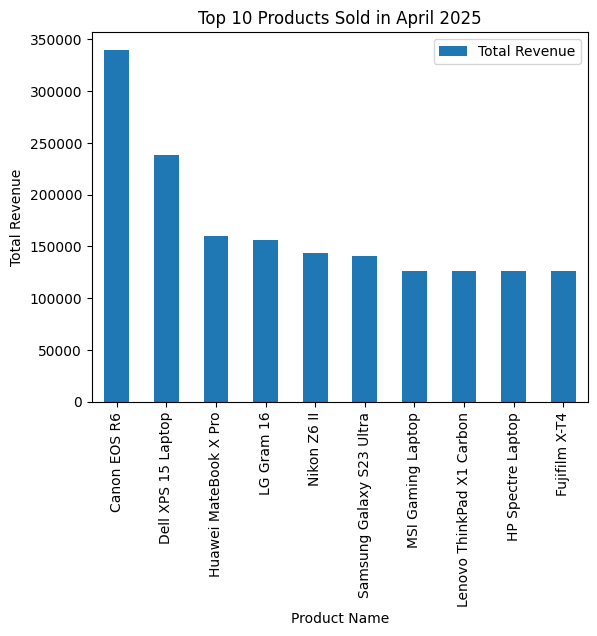

Okay, I have generated and displayed the bar chart of the top 10 products sold in April 2025, including the product name and total revenue, sorted by revenue in descending order.



In [50]:
result = await business_analysis_agent_4.run(
    (
        "Get me the top 10 products sold in 2025 April, "
        "including the product name, quantity sold, and revenue amount, "
        "sorted by the revenue amount in descending order, and display the result in a bar chart"
    ),
    deps=BusinessAnalysisDeps(
        engine=engine,
        all_tables=[Customer.__tablename__, Order.__tablename__, OrderItem.__tablename__, Product.__tablename__]
    )
)
print(result.data)

In [51]:
result.all_messages()

[ModelRequest(parts=[SystemPromptPart(content="You are a business analyst. You have access to a SQLite database that contains customer, order, and product information. Answer the questions as much as possible by guessing the context, or explore some tools you have on hand. Everytime you are answering a question, follow the observation-think-action pattern where you have to observe the existing situation, then think of the environment, and finally do some action on it. Review your action (next observation) and rethink what's the best action you can do until you can get the answer.", timestamp=datetime.datetime(2025, 4, 14, 1, 23, 16, 858620, tzinfo=datetime.timezone.utc), dynamic_ref=None, part_kind='system-prompt'), UserPromptPart(content='Get me the top 10 products sold in 2025 April, including the product name, quantity sold, and revenue amount, sorted by the revenue amount in descending order, and display the result in a bar chart', timestamp=datetime.datetime(2025, 4, 14, 1, 23, 16